# Versión Final: Ensamble NN + XGBoost con preprocesamiento oficial


Este notebook representa la versión final consolidada del modelo, que obtuvo el mejor RMSE test (~45.999 $).

Incluye:
- Preprocesamiento oficial (`preprocessing.py`)
- Red neuronal base (256 → 128 → 1 con `ReLU`)
- Modelo XGBoost
- Búsqueda del mejor α para combinar predicciones


In [1]:

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from preprocessing import get_preprocessor
import xgboost as xgb
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:

housing = pd.read_csv("housing.csv").dropna()
X = housing.drop("median_house_value", axis=1)
y = housing["median_house_value"]

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).astype(np.float32)
y_valid_scaled = y_scaler.transform(y_valid.values.reshape(-1, 1)).astype(np.float32)
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1)).astype(np.float32)

preprocessor = get_preprocessor(housing)
X_train_prep = preprocessor.fit_transform(X_train)
X_valid_prep = preprocessor.transform(X_valid)
X_test_prep = preprocessor.transform(X_test)


In [3]:

X_train_tensor = torch.tensor(X_train_prep.astype(np.float32))
X_valid_tensor = torch.tensor(X_valid_prep.astype(np.float32)).to(device)
X_test_tensor = torch.tensor(X_test_prep.astype(np.float32)).to(device)
y_train_tensor = torch.tensor(y_train_scaled)
y_valid_tensor = torch.tensor(y_valid_scaled).to(device)
y_test_tensor = torch.tensor(y_test_scaled).to(device)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)

class BaseNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.net(x)

model = BaseNet(X_train_tensor.shape[1]).to(device)
criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

best_rmse = float("inf")
patience = 12
trigger = 0

for epoch in range(100):
    model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        val_pred = model(X_valid_tensor).cpu().numpy()
        val_rmse = np.sqrt(mean_squared_error(
            y_scaler.inverse_transform(y_valid_tensor.cpu().numpy()),
            y_scaler.inverse_transform(val_pred.reshape(-1, 1))
        ))
    print(f"Epoch {epoch+1}, RMSE validación (NN): {val_rmse:.2f}")

    if val_rmse < best_rmse:
        best_rmse = val_rmse
        best_model_state = model.state_dict()
        trigger = 0
    else:
        trigger += 1
        if trigger >= patience:
            print("Early stopping.")
            break

model.load_state_dict(best_model_state)


Epoch 1, RMSE validación (NN): 57841.47
Epoch 2, RMSE validación (NN): 55423.55
Epoch 3, RMSE validación (NN): 55054.92
Epoch 4, RMSE validación (NN): 55375.18
Epoch 5, RMSE validación (NN): 54054.73
Epoch 6, RMSE validación (NN): 55428.97
Epoch 7, RMSE validación (NN): 54472.60
Epoch 8, RMSE validación (NN): 53889.99
Epoch 9, RMSE validación (NN): 53062.27
Epoch 10, RMSE validación (NN): 51883.11
Epoch 11, RMSE validación (NN): 52381.04
Epoch 12, RMSE validación (NN): 53406.26
Epoch 13, RMSE validación (NN): 51487.33
Epoch 14, RMSE validación (NN): 51686.86
Epoch 15, RMSE validación (NN): 51377.92
Epoch 16, RMSE validación (NN): 51104.60
Epoch 17, RMSE validación (NN): 50642.13
Epoch 18, RMSE validación (NN): 50743.26
Epoch 19, RMSE validación (NN): 51002.30
Epoch 20, RMSE validación (NN): 50655.53
Epoch 21, RMSE validación (NN): 50592.68
Epoch 22, RMSE validación (NN): 49772.45
Epoch 23, RMSE validación (NN): 50133.05
Epoch 24, RMSE validación (NN): 49507.49
Epoch 25, RMSE validación

<All keys matched successfully>

In [4]:

xgb_model = xgb.XGBRegressor(n_estimators=300, max_depth=6, learning_rate=0.05)
xgb_model.fit(X_train_prep, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

alpha = 0.00 → RMSE = 45834.75
alpha = 0.05 → RMSE = 45730.77
alpha = 0.10 → RMSE = 45663.46
alpha = 0.15 → RMSE = 45632.98
alpha = 0.20 → RMSE = 45639.40
alpha = 0.25 → RMSE = 45682.71
alpha = 0.30 → RMSE = 45762.81
alpha = 0.35 → RMSE = 45879.50
alpha = 0.40 → RMSE = 46032.50
alpha = 0.45 → RMSE = 46221.45
alpha = 0.50 → RMSE = 46445.92
alpha = 0.55 → RMSE = 46705.39
alpha = 0.60 → RMSE = 46999.28
alpha = 0.65 → RMSE = 47326.96
alpha = 0.70 → RMSE = 47687.72
alpha = 0.75 → RMSE = 48080.81
alpha = 0.80 → RMSE = 48505.47
alpha = 0.85 → RMSE = 48960.85
alpha = 0.90 → RMSE = 49446.12
alpha = 0.95 → RMSE = 49960.40
alpha = 1.00 → RMSE = 50502.81
✅ Mejor alpha: 0.15 con RMSE = 45632.98


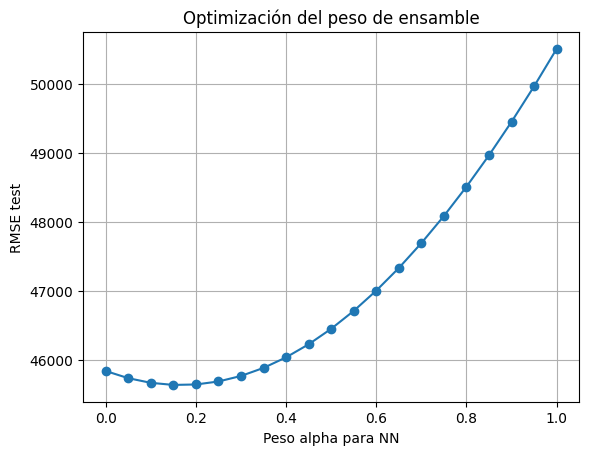

In [5]:

model.eval()
with torch.no_grad():
    nn_pred_scaled = model(X_test_tensor).cpu().numpy()
    nn_pred = y_scaler.inverse_transform(nn_pred_scaled.reshape(-1, 1)).flatten()

xgb_pred = xgb_model.predict(X_test_prep)

alphas = np.linspace(0, 1, 21)
rmse_scores = []

for alpha in alphas:
    ensemble_pred = alpha * nn_pred + (1 - alpha) * xgb_pred
    rmse = np.sqrt(mean_squared_error(y_test, ensemble_pred))
    rmse_scores.append(rmse)
    print(f"alpha = {alpha:.2f} → RMSE = {rmse:.2f}")

best_alpha = alphas[np.argmin(rmse_scores)]
print(f"✅ Mejor alpha: {best_alpha:.2f} con RMSE = {min(rmse_scores):.2f}")

# Gráfico
plt.plot(alphas, rmse_scores, marker="o")
plt.xlabel("Peso alpha para NN")
plt.ylabel("RMSE test")
plt.title("Optimización del peso de ensamble")
plt.grid(True)
plt.show()
